In [1]:
# 使用するパッケージの宣言
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

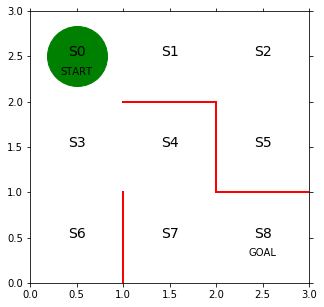

In [2]:
# 初期位置での迷路の様子

# 図を描く大きさと、図の変数名を宣言
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# 赤い壁を描く
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# 状態を示す文字S0～S8を描く
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 描画範囲の設定と目盛りを消す設定
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

# 現在地S0に緑丸を描画する
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)

## 1. 言葉の定義
### 1.1 マルコフ決定過程 $( S, A, P, r, \pi, \gamma)$
* 状態集合 $S$
* 行動集合 $A$
* 遷移確率 $P : S \times A \times S \mapsto [0, 1]$ <br>
$ P(s,\ a,\ s') = $ 状態 $s$ で行動 $a$ をとった時に状態 $s'$ に遷移する確率
* 報酬関数 $r : S \times A \times S \mapsto \mathbb{R}$ <br>
$ r(s,\ a,\ s') = $ 状態 $s$で行動 $a$ をとり, 状態 $s'$ に遷移した時にもらえる報酬.
* 方策(政策) $ \pi : S \times A \mapsto [0, 1]$ <br>
$ \pi (s,\ a) = $ 状態 $s$ で行動 $a$ をとる確率.
* 割引率 $\gamma,\ 0 < \gamma < 1$

迷路ゲームの例
* $S = \{ S0,\ S1, \dots,\ S8 \}$
* $A = \{ \text{上},\ \text{下},\ \text{右},\ \text{左} \}$
* $P(S0,\ \text{右},\ S1) = 1,\ P(S0,\ \text{右},\ S2) = 0, \dots $ <br>
迷路ゲームにおいては, 行動に対して次の状態が一意に決まる.
* $r(S7, \text{右}, S8) = 1.0,\ r(S0, \text{右}, S1) = 0.0,\ \dots $ <br>
ゴールについた時に報酬1.0が貰えると定める.それ以外は報酬0

## 2. 迷路ゲームの概要
最適な方策(政策) $ \pi : S \times A \mapsto [0, 1]$ を求めたい.

つまり, 
$$\pi(S0, \text{下}) \simeq 1,\ \pi(S3, \text{右})  \simeq 1, \pi(S4, \text{下})  \simeq 1,\ \pi(S7, \text{右})  \simeq 1$$
となって4手(最適)でゴールできるように$\pi$を学習したい.

今回は **方策勾配法** を使って$\pi$の学習を行う.


## 3. 方策勾配法

### 3.1 方策関数を $\boldsymbol{\theta}$ を用いて定義
$\pi$を媒介変数 $\boldsymbol{\theta} = ( \theta_{(S0, \text{上})},\ \theta_{(S0, \text{下})},\ ,\ \dots \theta_{(S1, \text{上})},\ \dots,\ \theta_{(S7, \text{右})} ) $ を用いて表すことにする.

$$\pi( s_i,\ a_j) = \dfrac{ \exp{ \beta \theta_{( s_i,\ a_j)}} } { \sum_{ k } \exp { \beta \theta_{( s_i,\ a_k)}} }$$

例 :
$$ \pi( S0,\ \text{下} ) = \dfrac{ \exp{ \beta \theta_{( S0,\ \text{下})}} } { \exp{  \beta \theta_{( S0,\ \text{下})}} +\exp{ \beta \theta_{( S0,\ \text{上})}} + \exp{ \beta  \theta_{( S0,\ \text{左})}} + \exp{ \beta \theta_{( S0,\ \text{右})}} } $$

$\beta$は逆温度定数. 温度パラメータをつけることの意味は以下を参照.
https://qiita.com/nkriskeeic/items/db3b4b5e835e63a7f243

またプログラムでは, $\boldsymbol{\theta}$をnumpy行列で表しているけど数学上は <font color="Red">ベクトル</font>
として考えるので注意!!


In [3]:
# 初期の方策を決定するパラメータtheta_0を設定

# 行は状態0～7、列は移動方向で↑、→、↓、←を表す
theta_0 = np.array([[np.nan, 1, 1, np.nan],  # s0
                    [np.nan, 1, np.nan, 1],  # s1
                    [np.nan, np.nan, 1, 1],  # s2
                    [1, 1, 1, np.nan],  # s3
                    [np.nan, np.nan, 1, 1],  # s4
                    [1, np.nan, np.nan, np.nan],  # s5
                    [1, np.nan, np.nan, np.nan],  # s6
                    [1, 1, np.nan, np.nan],  # s7、※s8はゴールなので、方策はなし
                    ])

In [4]:
# 方策パラメータthetaを行動方策piにソフトマックス関数で変換する手法の定義


def softmax_convert_into_pi_from_theta(theta):
    '''ソフトマックス関数で割合を計算する'''

    beta = 1.0
    [m, n] = theta.shape  # thetaの行列サイズを取得
    pi = np.zeros((m, n))

    exp_theta = np.exp(beta * theta)  # thetaをexp(theta)へと変換

    for i in range(0, m):
        # pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
        # simpleに割合の計算の場合

        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])
        # softmaxで計算の場合

    pi = np.nan_to_num(pi)  # nanを0に変換

    return pi

In [5]:
# 初期の方策pi_0を求める
pi_0 = softmax_convert_into_pi_from_theta(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.5        0.5       ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.5        0.5       ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]]


In [6]:
# 行動aと1step移動後の状態sを求める関数を定義


def get_action_and_next_s(pi, s):
    direction = ["up", "right", "down", "left"]
    # pi[s,:]の確率に従って、directionが選択される
    next_direction = np.random.choice(direction, p=pi[s, :])

    if next_direction == "up":
        action = 0
        s_next = s - 3  # 上に移動するときは状態の数字が3小さくなる
    elif next_direction == "right":
        action = 1
        s_next = s + 1  # 右に移動するときは状態の数字が1大きくなる
    elif next_direction == "down":
        action = 2
        s_next = s + 3  # 下に移動するときは状態の数字が3大きくなる
    elif next_direction == "left":
        action = 3
        s_next = s - 1  # 左に移動するときは状態の数字が1小さくなる

    return [action, s_next]

In [7]:
# 迷路を解く関数の定義、状態と行動の履歴を出力


def goal_maze_ret_s_a(pi):
    s = 0  # スタート地点
    s_a_history = [[0, np.nan]]  # エージェントの移動を記録するリスト

    while (1):  # ゴールするまでループ
        [action, next_s] = get_action_and_next_s(pi, s)
        s_a_history[-1][1] = action
        # 現在の状態（つまり一番最後なのでindex=-1）の行動を代入

        s_a_history.append([next_s, np.nan])
        # 次の状態を代入。行動はまだ分からないのでnanにしておく

        if next_s == 8:  # ゴール地点なら終了
            break
        else:
            s = next_s

    return s_a_history

In [8]:
# 初期の方策で迷路を解く
s_a_history = goal_maze_ret_s_a(pi_0)
print(s_a_history)
print("迷路を解くのにかかったステップ数は" + str(len(s_a_history) - 1) + "です")

[[0, 2], [3, 0], [0, 2], [3, 2], [6, 0], [3, 0], [0, 1], [1, 1], [2, 2], [5, 0], [2, 3], [1, 3], [0, 1], [1, 1], [2, 3], [1, 1], [2, 2], [5, 0], [2, 3], [1, 1], [2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 3], [1, 3], [0, 1], [1, 1], [2, 3], [1, 1], [2, 3], [1, 1], [2, 3], [1, 3], [0, 1], [1, 3], [0, 2], [3, 2], [6, 0], [3, 1], [4, 2], [7, 0], [4, 3], [3, 2], [6, 0], [3, 1], [4, 3], [3, 1], [4, 2], [7, 0], [4, 2], [7, 1], [8, nan]]
迷路を解くのにかかったステップ数は56です


### 3.2 更新式の導出

方策 $\pi$ の良さを表す関数 $ J( \boldsymbol{\theta} ) : \mathbb{R}^{ |S| \cdot |A| } \mapsto \mathbb{R}$ を考える.

この時, $J( \boldsymbol{\theta} )$ を最大化するような $\boldsymbol{\theta}$ を最急降下法によって求める.

$$  \boldsymbol{\theta}^{(k+1)} \leftarrow \boldsymbol{\theta}^{(k)} + \eta \nabla J( \boldsymbol{\theta} )  \quad ( \eta : \text{学習率} )$$

最大化したいので, $+$になっていることに注意!!

#### 3.2.1 $ J( \boldsymbol{\theta} )$ の定義
1. 平均報酬による定義
$$ J( \boldsymbol{\theta} ) = \lim_{n \to \infty} \dfrac{1}{n} \mathbb{E}[ \sum_{t=1}^n r_t ] $$
2. 割引報酬による定義
$$  J( \boldsymbol{\theta} ) = \lim_{n \to \infty} \mathbb{E}[ \sum_{t=1}^n \gamma^{t-1} r_t  ; s_0 ] $$

#### 3.2.2 方策勾配定理
式変形すると, どちらの定義でも以下のようになる.( 式変形参考 : [book](https://github.com/komi1230/Resume/tree/master/book_reinforcement) p52あたり )
$$ \nabla  J( \boldsymbol{\theta} ) = \mathbb{E}[ Q^{\pi}(s, a) \nabla \log \pi(s,a) ] \quad ( \text{方策勾配定理} ) $$ 

#### 3.2.3 REINFORCE アルゴリズム
期待値をサンプリングによって近似する. ( $M$ : 試行回数, $T$ : ステップ数, $M$は十分大きいと仮定. )
$$ \nabla  J( \boldsymbol{\theta} ) \simeq \dfrac{1}{M} \sum_{m=1}^{M} \dfrac{1}{T} \sum_{t=1}^{T} Q^{\pi}(s_t, a_t) \nabla \log \pi(s_t,a_t)$$

さらに$Q^{\pi}(s, a)$が未知なので, 収益$R_t$で近似する.
$$ 
Q^{\pi}(s,a) \simeq R_t = 
\begin{cases} \sum_{k=1}^{T} r_{t+k} \ ( \text{有限エピソードの時はこちらでも良い.} ) \\ 
\sum_{k=1}^{\infty} \gamma^{k-1} r_{t+k} 
\end{cases} 
$$

( 参考 : [Policy Gradient Methods for Reinforcement Learning with Function Approximation](https://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf) )

ベースメントを用いて分散を小さくする等の工夫もあるらしい.

最終的に, 
$$
\nabla  J( \boldsymbol{\theta} ) \simeq \dfrac{1}{M} \sum_{m=1}^{M} \dfrac{1}{T} \sum_{t=1}^{T} R_t \nabla \log \pi(s_t,a_t) 
$$

#### 3.2.4 迷路ゲームの場合の方策勾配法.
ゴールに着いた時にのみ報酬1がもらえるとする.つまり, 
$r_t = \begin{cases} 1 \ ( t = T ) \\ 0 \ ( otherwise ) \end{cases}$
であり, 
$$R_t = \sum_{k=1}^{T} r_{t+k} = 1$$

また, 1エピソードを得るごとに更新しているので, $M = 1$として良い.

方策関数はsoftmax関数で定義していた. 
$$ \pi( s_i,\ a_j) = \dfrac{ \exp{ \beta \theta_{( s_i,\ a_j)}} } { \sum_{ k } \exp { \beta \theta_{( s_i,\ a_k)}} }$$

これらを使って式を変形すると
$$ 
\nabla  J( \boldsymbol{\theta} ) = 
( \dfrac{ \partial  J( \boldsymbol{\theta} )}{ \partial \theta_{( S0,\ \text{下})}},\ 
\dfrac{ \partial  J( \boldsymbol{\theta} )}{ \partial \theta_{( S0,\ \text{上})}},\ \dots,\ 
\dfrac{ \partial  J( \boldsymbol{\theta} )}{ \partial \theta_{( S7,\ \text{右})}} )
$$

$$ 
\begin{eqnarray*}
\dfrac{ \partial  J( \boldsymbol{\theta} )}{ \partial \theta_{(s_i, a_j)}} &\simeq&
\dfrac{1}{T} \sum_{t=1}^T \dfrac{ \partial}{ \partial \theta_{(s_i, a_j)}} ( \log \exp{\beta \theta_{(s_t, a_t)}} - \log \sum_{k=1}^4 \exp{\beta \theta_{(s_t, a_k)}} )  \\
&=& \dfrac{1}{T} ( \sum_{s_t = s_i,\ a_t = a_j} \beta 
- \sum_{s_t = s_i} \dfrac{\beta \exp{\beta \theta_{(s_i, a_j)}}}{\sum_{k=1}^4 \exp{\beta \theta_{(s_i, a_k)}}} )\\
&=& \dfrac{\beta}{T} ( N( s_t = s_i, a_t = a_j) - N(s_t = s_i) \pi(s_i, a_j) )\\
\end{eqnarray*}
$$

$\beta = 1.0$より, 書籍の式が求まった.


In [9]:
# thetaの更新関数を定義します

def update_theta(theta, pi, s_a_history):
    eta = 0.1 # 学習率
    T = len(s_a_history) - 1  # ゴールまでの総ステップ数

    [m, n] = theta.shape  # thetaの行列サイズを取得
    delta_theta = theta.copy()  # Δthetaの元を作成、ポインタ参照なので、delta_theta = thetaはダメ

    # delta_thetaを要素ごとに求めます
    for i in range(0, m):
        for j in range(0, n):
            if not(np.isnan(theta[i, j])):  # thetaがnanでない場合

                SA_i = [SA for SA in s_a_history if SA[0] == i]
                # 履歴から状態iのものを取り出すリスト内包表記です

                SA_ij = [SA for SA in s_a_history if SA == [i, j]]
                # 状態iで行動jをしたものを取り出す

                N_i = len(SA_i)  # 状態iで行動した総回数
                N_ij = len(SA_ij)  # 状態iで行動jをとった回数
                
                # 初版では符号の正負に間違いがありました（修正日：180703）
                #delta_theta[i, j] = (N_ij + pi[i, j] * N_i) / T
                delta_theta[i, j] = (N_ij - pi[i, j] * N_i) / T

    new_theta = theta + eta * delta_theta

    return new_theta

In [10]:
# 方策の更新
new_theta = update_theta(theta_0, pi_0, s_a_history)
pi = softmax_convert_into_pi_from_theta(new_theta)
print(pi)

[[0.         0.50044643 0.49955357 0.        ]
 [0.         0.50133928 0.         0.49866072]
 [0.         0.         0.49955357 0.50044643]
 [0.33293663 0.33353169 0.33353169 0.        ]
 [0.         0.         0.50044643 0.49955357]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.50044643 0.49955357 0.         0.        ]]


In [11]:
# 方策勾配法で迷路を解く

# 初版で、def update_thetaに間違いがあった関係で、終了条件を変更します（修正日：180703）
#stop_epsilon = 10**-8  # 10^-8よりも方策に変化が少なくなったら学習終了とする
stop_epsilon = 10**-4  # 10^-4よりも方策に変化が少なくなったら学習終了とする


theta = theta_0
pi = pi_0

is_continue = True
count = 1
while is_continue:  # is_continueがFalseになるまで繰り返す
    s_a_history = goal_maze_ret_s_a(pi)  # 方策πで迷路内を探索した履歴を求める
    new_theta = update_theta(theta, pi, s_a_history)  # パラメータΘを更新
    new_pi = softmax_convert_into_pi_from_theta(new_theta)  # 方策πの更新

    #print(np.sum(np.abs(new_pi - pi)))  # 方策の変化を出力
    #print("迷路を解くのにかかったステップ数は" + str(len(s_a_history) - 1) + "です")

    if np.sum(np.abs(new_pi - pi)) < stop_epsilon:
        is_continue = False
    else:
        theta = new_theta
        pi = new_pi

In [12]:
# 最終的な方策を確認
np.set_printoptions(precision=3, suppress=True)  # 有効桁数3、指数表示しないという設定
print(pi)

[[0.    0.013 0.987 0.   ]
 [0.    0.269 0.    0.731]
 [0.    0.    0.496 0.504]
 [0.01  0.976 0.014 0.   ]
 [0.    0.    0.986 0.014]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.015 0.985 0.    0.   ]]


In [13]:
# エージェントの移動の様子を可視化します
# 参考URL http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
from matplotlib import animation
from IPython.display import HTML


def init():
    # 背景画像の初期化
    line.set_data([], [])
    return (line,)


def animate(i):
    # フレームごとの描画内容
    state = s_a_history[i][0]  # 現在の場所を描く
    x = (state % 3) + 0.5  # 状態のx座標は、3で割った余り+0.5
    y = 2.5 - int(state / 3)  # y座標は3で割った商を2.5から引く
    line.set_data(x, y)
    return (line,)


#　初期化関数とフレームごとの描画関数を用いて動画を作成
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(
    s_a_history), interval=200, repeat=False)

HTML(anim.to_jshtml())